# Create embeddings of faces

Some small tests for creating embeddings of some faces, before testing this on our archive of terabytes of fotos.

Goal:
* Get embeddings of faces
* Store in some vectorstore
* Get some stats from the collected embeddings: number of unique faces, number of embeddings per face


In [101]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib import patches
import numpy as np
import typing
import pandas as pd

Same 3 test images:
* Carolien on her own, having a drink
* Carolien on her own, again having a drink, but my face is reflected on some glass wall
* Carolien with her godchild on her lap, with their faces very close to each other

In [102]:
img1_name: str = 'test_files/test-image-carolien-montreux-2018.jpg'
img2_name: str = 'test_files/test-image-carolien-geneva-2018.jpg'
img3_name: str = 'test_files/test-image-carolien-bern-2018-with-child.jpg'

all_image_names: typing.List[str] = [img1_name, img2_name, img3_name]

Display the test images:

<Figure size 900x300 with 0 Axes>

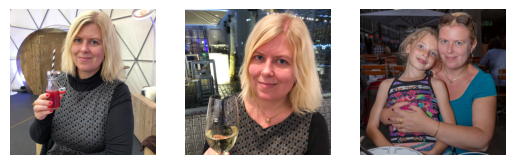

In [103]:
def show_images_in_row(filenames: typing.List[str]) -> None:
  """ show multiple images in a row """
  plt.figure(figsize=(len(filenames)*3., 3.))
  _, _axes = plt.subplots(1, len(filenames))
  axes: typing.List[Axes] = typing.cast(typing.List[Axes], _axes)
  for i, filename in enumerate(filenames):
    axes[i].set_axis_off()
    img: np.ndarray = plt.imread(filename)
    axes[i].imshow(img)

show_images_in_row(all_image_names)

Add some wrapper as it's not that convenient to work with a list of dicts that contains both dicts and lists.

In [104]:
class EmbeddingOfFaceWrapper:
  """ wrap the result of the DeepFace.represent call so you don't have to parse a dict containing other dicts and lists """
  def __init__(self, represent_retval: typing.Dict[str,typing.Any]) -> None:
    self.embedding: typing.List[float] = represent_retval['embedding']
    self.facial_area: typing.Dict[str,int] = represent_retval['facial_area']
    self.face_confidence: np.float64 = represent_retval['face_confidence']

def wrap_embeddings(extracted_embeddings: typing.List[typing.Dict[str,typing.Any]]) -> typing.List[EmbeddingOfFaceWrapper]:
  """ convert the list of dicts of extracted faces into more convenient objects """
  return [EmbeddingOfFaceWrapper(x) for x in extracted_embeddings]

Get the embeddings of just a single image with the default model and backend:

In [105]:
embedding_objs: typing.List[EmbeddingOfFaceWrapper] = wrap_embeddings(DeepFace.represent(img_path = img3_name))
for detected_embedding in embedding_objs:
  print(f"Length of embedding: {len(detected_embedding.embedding)}")
  facial_area: typing.Dict[str,int] = detected_embedding.facial_area
  print(f"Face detected at {facial_area}")
  face_confidence: np.float64 = detected_embedding.face_confidence
  print(f"Face was detected with confidence {face_confidence}")

Length of embedding: 4096
Face detected at {'x': 519, 'y': 132, 'w': 264, 'h': 264}
Face was detected with confidence 10.562721127585974


Check the number of dimensions of the embedding vector and the number of detected faces for a couple of model & backend combinations.

In [106]:
model_names: typing.List[str] = ['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'SFace']
backends: typing.List[str] = ['opencv','retinaface','mtcnn', 'ssd']

array: np.ndarray = np.zeros((len(model_names)*len(backends), 4), dtype='<U10')


for i, model_name in enumerate(model_names):
  for j, backend in enumerate(backends):
    array[i*len(backends) + j, 0] = model_name
    array[i*len(backends) + j, 1] = backend
    embedding_objs: typing.List[typing.Dict[str,typing.Any]] = DeepFace.represent(img_path = img3_name, model_name=model_name, detector_backend=backend)
    array[i*len(backends) + j, 2] = len(embedding_objs)
    first_embedding: typing.List[float] = embedding_objs[0]['embedding']
    array[i*len(backends) + j, 3] = len(first_embedding)

df = pd.DataFrame(array.tolist(), columns=['Model name', 'Backend', 'Number of detected faces', 'Number of dimensions'])
df.style.set_table_styles([{"selector":"tbody tr:nth-child(even)","props":[("background-color","lightgrey")]}])
display(df.style)


1/1 [==============================] - 0s 15ms/step


,Model name,Backend,Number of detected faces,Number of dimensions
0,VGG-Face,opencv,1,4096
1,VGG-Face,retinaface,2,4096
2,VGG-Face,mtcnn,2,4096
3,VGG-Face,ssd,2,4096
4,Facenet,opencv,1,128
5,Facenet,retinaface,2,128
6,Facenet,mtcnn,2,128
7,Facenet,ssd,2,128
8,Facenet512,opencv,1,512
9,Facenet512,retinaface,2,512


Let's the model VGG-Face but with the retinaface backend. List all the faces in the test images:

In [107]:
class FaceInfo:
  """ The embedding and some info about a certain face in a certain image """
  def __init__(self, img_name: str, face_number: int, embedding_info: EmbeddingOfFaceWrapper):
    """ face_number: the number of the face within the image as there might be multiple faces on an image """
    self.img_name: str = img_name
    self.face_number: int = face_number
    self.embedding_info: EmbeddingOfFaceWrapper = embedding_info

  def __repr__(self) -> str:
    return f"Face {self.face_number} in image {self.img_name} with embedding of size {len(self.embedding_info.embedding)}" \
    + f" at {self.embedding_info.facial_area} with confidence {self.embedding_info.face_confidence}"

all_faces: typing.List[FaceInfo] = []

model_name = "VGG-Face"
backend = "retinaface"
for img_name in all_image_names:
  embedding_objs: typing.List[EmbeddingOfFaceWrapper] = wrap_embeddings(DeepFace.represent(img_path = img_name, model_name=model_name, detector_backend=backend))
  for face_number, embedding_obj in enumerate(embedding_objs):
    face_info = FaceInfo(img_name, face_number, embedding_obj)
    all_faces.append(face_info)

for face in all_faces:
  print(face)

Face 0 in image test_files/test-image-carolien-montreux-2018.jpg with embedding of size 4096 at {'x': 423, 'y': 90, 'w': 242, 'h': 346} with confidence 0.9995160102844238
Face 0 in image test_files/test-image-carolien-geneva-2018.jpg with embedding of size 4096 at {'x': 444, 'y': 155, 'w': 342, 'h': 487} with confidence 0.9991294741630554
Face 1 in image test_files/test-image-carolien-geneva-2018.jpg with embedding of size 4096 at {'x': 42, 'y': 246, 'w': 54, 'h': 66} with confidence 0.9645575881004333
Face 0 in image test_files/test-image-carolien-bern-2018-with-child.jpg with embedding of size 4096 at {'x': 547, 'y': 111, 'w': 221, 'h': 303} with confidence 0.9995571970939636
Face 1 in image test_files/test-image-carolien-bern-2018-with-child.jpg with embedding of size 4096 at {'x': 349, 'y': 188, 'w': 201, 'h': 240} with confidence 0.9991269707679749


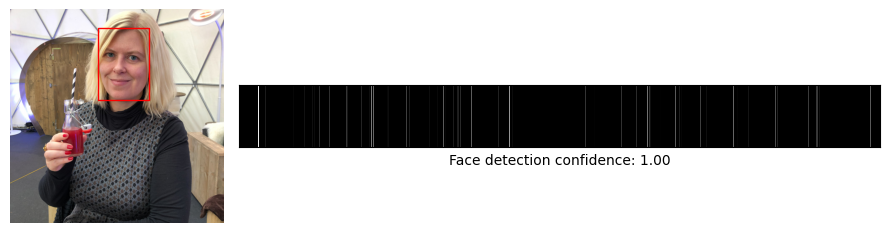

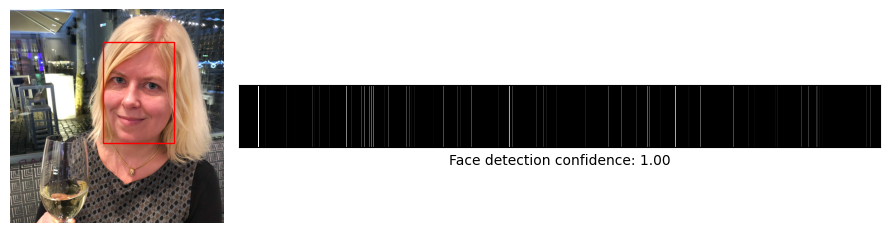

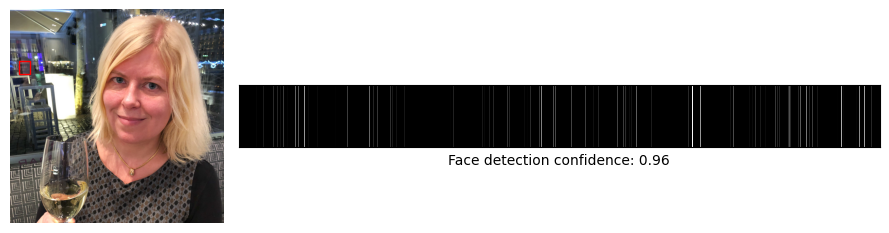

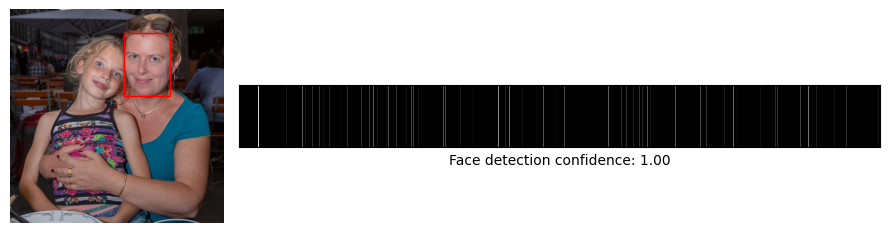

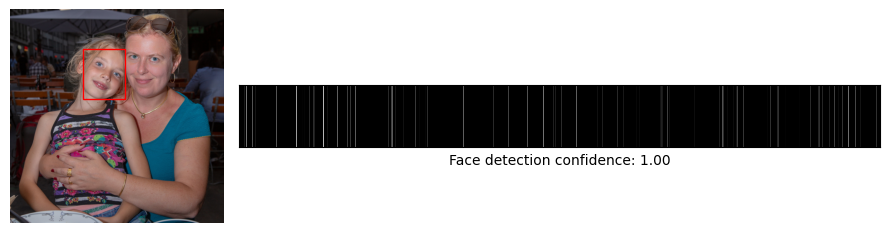

In [108]:
def show_detected_face_with_embedding(face_info: FaceInfo) -> None:
  """ show detected face with a heatmap of the embedding """
  fig: Figure = plt.figure(figsize=(9., 3.))
  gs: GridSpec = GridSpec(1, 2, width_ratios=[1, 3])

  # The image with the detected face area
  ax1: Axes = fig.add_subplot(gs[0, 0])
  ax1.set_axis_off()
  img: np.ndarray = plt.imread(face_info.img_name)
  ax1.imshow(img)
  face_area: typing.Dict[str,int] = face_info.embedding_info.facial_area
  rect = patches.Rectangle((face_area['x'], face_area['y']), face_area['w'], face_area['h'], linewidth=1, edgecolor='r', facecolor='none')
  ax1.add_patch(rect)

  # The embedding as some heatmap
  ax2: Axes = fig.add_subplot(gs[0, 1])
  embedding = face.embedding_info.embedding
  # extend the one dimensional list a bit so it's easier to see
  result_array = np.tile(np.array(embedding), (400, 1))
  ax2.imshow(result_array, cmap='gray', interpolation='nearest')
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xlabel(f"Face detection confidence: {face.embedding_info.face_confidence:.2f}")
  plt.tight_layout()


for face in all_faces:
  show_detected_face_with_embedding(face)